# Part 1:Loading and Visualizing Data
we start the exercise by first loading and visualizing the dataset.
you will be working with a dataset that contains handwritten digits.

In [223]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib import cm 
import matplotlib 
import scipy.optimize as opt
#This package is the evaluation estimate
from sklearn.metrics import classification_report #
%matplotlib inline

In [224]:
#Setup the parameters you will use for this exercise
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [225]:
#Load Training Data
def load_data(path,transpose=True):
    data = sio.loadmat(path)
    y = data.get('y') #5000*1
    y = y.reshape(y.shape[0]) #make it back to column vector
    
    X = data.get('X') #5000*400
    
    if transpose:
        #for this dataset,you need a transpose to get the orientation right
        X = np.array([im.reshape((20,20)).T for im in X])
        print(X.shape)
        # and I flat the image again to preserve the vector presentataion
        X = np.array([im.reshape(400) for im in X])
        print(X.shape)
    
    return X,y

In [226]:
X, y = load_data('ex4data1.mat')

(5000, 20, 20)
(5000, 400)


In [227]:
def plot_100_image(X):
    """
    sample 100 image and show them 
    assume the image is square
    X:(5000,400)
    """
    size = int(np.sqrt(X.shape[1]))
    #sample 100 image,reshape,reorg it 
    sample_idx = np.random.choice(np.arange(X.shape[0]),100) #100*400
    sample_images = X[sample_idx,:]
    
    fig, ax_array = plt.subplots(nrows=10,ncols=10,\
                                 sharey=True,sharex=True,figsize=(8,8))
    for r in range(10):
        for c in range(10):
            ax_array[r,c].matshow(sample_images[10*r+c].reshape((size,size)),\
                                 cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

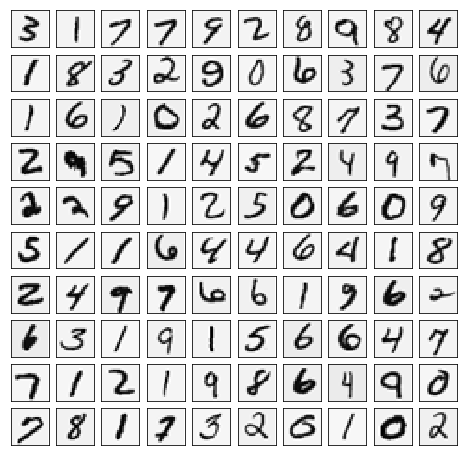

In [228]:
plot_100_image(X)
plt.show()

# Part 2: Loading Parameters
In this part of the exercise,we load some pre-initialized neural network parameters.

In [229]:
print("Loading Saved Neural Network Parameters....")
theta = sio.loadmat('ex4weights.mat')
#Unroll parameters
theta1 = theta['Theta1']  #25*401
theta2 = theta['Theta2']  #10*26
print(theta1.shape,theta2.shape)
#nn_params = np.vstack((theta1,theta2))

Loading Saved Neural Network Parameters....
(25, 401) (10, 26)


# Part 3: Compute Cost (Feedforward)
To the neural network, you should first start by implementing the
feedforward part of the neural network that returns the cost only. You
should complete the code in nnCostFunction.m to return cost. After
implementing the feedforward to compute the cost, you can verify that
your implementation is correct by verifying that you get the same cost
as us for the fixed debugging parameters.
We suggest implementing the feedforward cost *without* regularization
first so that it will be easier for you to debug. Later, in part 4, you
will get to implement the regularized cost.

In [230]:
print("Feedforward using Neural Network....")
#Weight regularization parameter (we set this to 0 here)
lamda = 0
X_raw,y_raw = load_data('ex4data1.mat',transpose=False)
X = np.hstack((np.ones((X_raw.shape[0],1)),X_raw))
X.shape

Feedforward using Neural Network....


(5000, 401)

In [231]:
y_raw
#注意这里要对标签y处理一下，变成一个矩阵
def expend_y(y):
    '''
    expend 5000*1 into 5000*10
    where y=10 -> [0,0,0,0,0,0,0,0,0,1]
    '''
    res = []
    for i in y:
        y_array = np.zeros(10)
        y_array[i-1] = 1
        
        res.append(y_array) #注意这里res还是列表，才有append
    return np.array(res)    #注意这里把列表转换为数组

In [232]:
y = expend_y(y_raw)
print(y)
print(y.shape)

[[ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
(5000, 10)


## (1).读取权重

In [233]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'],data['Theta2']

In [234]:
theta1,theta2 = load_weight('ex4weights.mat')
theta1.shape,theta2.shape

((25, 401), (10, 26))

In [235]:
#序列化２个矩阵
#在这个nn架构中，有theta1(25,401),theta2(10,26),它们的梯度是delta1,delta2
def serialize(a,b):
    return np.concatenate((np.ravel(a),np.ravel(b)))

### 这里为什么要扁平化theta?

In [236]:
#这里要扁平化参数，25*401+10*26 = 10285 
theta = serialize(theta1,theta2) 
theta.shape

(10285,)

## (2).feed forward(前馈)
> (400 + 1) -> (25 + 1) -> (10)

<img style="float: left;" src="../img/nn_model.png">

In [237]:
def feed_forward(theta,X):
    """
    apply to architecture 400+1 * 25+1 * 10
    X:5000*401
    """
    theta1,theta2 = deserialize(theta) #把和起来的theta在分开。why?
    m = X.shape[0]
    a1 = X #5000*401
    z2 = a1 @ theta1.T #5000*25
    a2 = np.hstack((np.ones((m,1)),sigmoid(z2))) #5000*26
    
    z3 = a2 @ theta2.T #5000*10
    h = sigmoid(z3) #5000*10 ,this is h_theta(x)
    
    return a1, z2, a2, z3,h # you need all those for backprop

In [238]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [239]:
def deserialize(seq):
    '''
    into ndarray of (25,401),(10,26)
    '''
    return seq[:25 * 401].reshape(25,401),seq[25 * 401:].reshape(10,26)

In [240]:
a1,z2,a2,z3,h= feed_forward(theta,X)
print(h.shape)
print(theta1.shape,theta2.shape)
print(z2)
print(a2)
print(z3)

(5000, 10)
(25, 401) (10, 26)
[[ -2.93684669  -2.45058587   4.95510333 ...,   3.56635593   2.81388641
   -2.1195223 ]
 [ -4.81302157  -2.92257775   2.6445065  ...,   2.10497303   4.69948787
   -2.76096862]
 [ -4.24056958  -3.68698052   5.99656398 ...,   1.54599347   3.08971226
   -2.32990819]
 ..., 
 [ -0.86267303   1.00939507  -1.67526051 ...,   1.8185898   -3.18203449
   -1.72539781]
 [  1.74408423  -0.58216518  -1.49164167 ...,   4.17481481  -0.96739536
   -3.08906563]
 [  3.55683614 -12.11330792   5.01096205 ...,   7.17585008   2.15484114
   -2.9424052 ]]
[[  1.00000000e+00   5.03618685e-02   7.93957162e-02 ...,   9.72517962e-01
    9.43421623e-01   1.07213787e-01]
 [  1.00000000e+00   8.05782163e-03   5.10486829e-02 ...,   8.91385592e-01
    9.90982126e-01   5.94701645e-02]
 [  1.00000000e+00   1.41949887e-02   2.44354705e-02 ...,   8.24334311e-01
    9.56466386e-01   8.86760824e-02]
 ..., 
 [  1.00000000e+00   2.96781175e-01   7.32901746e-01 ...,   8.60396828e-01
    3.98474223e-

## (3).Cost Function 
$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\left[\begin{array}{c}-{{y}_{k}}^{(i)}\log(({h}_{\theta}({x}^{(i)}){)}_{k})-(1-{{y}_{k}}^{(i)})\log(1-{({h}_{\theta}({x}^{(i)}))}_{k}) \end{array}\right]$$

Think about this ,now we have y and ${h}_{\theta}$ $\in$ ${R}^{5000×10}$  
If you just ignore the m and k dimension ,pairwise this computation is trivial.  
The eqation = $y*\log({h}_{\theta})-(1-y)*\log(1-{h}_{\theta})$  
all you need to do after pairwise computation is sums this 2d array up and divided by m

In [241]:
def costFunction(theta, X, y):
    """
    calculate cost
    y:(m,k) ndarray
    """
    m = X.shape[0]  # get the data size m
    theta1,theta2 = deserialize(theta)
    _, _, _, _, h = feed_forward(theta, X)

    # np.multiply is pairwise operation
    pair_computation = -y*np.log(h) - (1-y) * np.log(1-h)
    #print(pair_computation.shape,type(pair_computation))
    return pair_computation.sum() / m


In [242]:
costFunction(theta,X,y)

0.28762916516131892

## (4).Regularized cost function
$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\left[\begin{array}{c}-{{y}_{k}}^{(i)}\log(({h}_{\theta}({x}^{(i)}){)}_{k})-(1-{{y}_{k}}^{(i)})\log(1-{({h}_{\theta}({x}^{(i)}))}_{k}) \end{array}\right] + \frac{\lambda}{2m}\left[\begin{array}{ccc}\sum_{j=1}^{25}\sum_{k=1}^{400}{({{\Theta}_{j,k}}^{(1)})}^{2}+\sum_{j=1}^{10}\sum_{k=1}^{25}{({{\Theta}_{j,k}}^{(2)})}^{2}\end{array}\right]$$  
The first column of theta1 and theta2 is intercept $\theta$,just forget 
them when you do regularization

In [243]:
def reg_theta(theta1,theta2):
    #正则化的那一项只是排除theta0后，每一层的theta0矩阵的和
    #print(theta1.shape)
    #print(theta2.shape)
    reg_theta1 = theta1[:,1:]
    reg_theta2 = theta2[:,1:]
    #print(reg_theta1.shape)
    #print(reg_theta2.shape)
    
    return reg_theta1,reg_theta2

In [244]:
reg_theta1,reg_theta2 = reg_theta(theta1,theta2)

In [245]:
def regularized_costFunction(theta,X,y,lamda=1):
    m = X.shape[0]  # get the data size m
    _, _, _, _, h = feed_forward(theta, X)
    theta1,theta2 = deserialize(theta)
    reg_theta1,reg_theta2 = reg_theta(theta1,theta2)
    # np.multiply is pairwise operation
    reg_costFunction = np.sum(-y*np.log(h) - (1-y) * np.log(1-h)) / m +\
    lamda*(np.sum(np.power(reg_theta1,2)) + \
           np.sum(np.power(reg_theta2,2))) / (2*m)
    
    return reg_costFunction

In [246]:
lamda = 1
regularized_costFunction(theta,X,y,lamda)

0.38376985909092365

# Part 4:反向传播

## (1) 读取数据和权重过程与前向传播相同

In [247]:
X.shape,y.shape

((5000, 401), (5000, 10))

In [248]:
theta1.shape,theta2.shape

((25, 401), (10, 26))

In [249]:
theta.shape

(10285,)

## (2) Sigmoid Gradient

In [250]:
def sigmoidGradient(z):
    return sigmoid(z)*(1-sigmoid(z))

In [251]:
sigmoidGradient(0)

0.25

## (3) theta gradient
误差矩阵

In [252]:
print(a1.shape)
print(z2.shape)
print(a2.shape)
print(z3.shape)
print(h.shape)
print(theta1.shape)
print(theta2.shape)

(5000, 401)
(5000, 25)
(5000, 26)
(5000, 10)
(5000, 10)
(25, 401)
(10, 26)


In [253]:
def gradient(theta, X, y):
    # initialize
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    delta1 = np.zeros(t1.shape)  # (25, 401)
    delta2 = np.zeros(t2.shape)  # (10, 26)

    a1, z2, a2, z3, h = feed_forward(theta, X)

    for i in range(m):
        a1i = a1[i, :]  # (1, 401)
        z2i = z2[i, :]  # (1, 25)
        a2i = a2[i, :]  # (1, 26)

        hi = h[i, :]    # (1, 10)
        yi = y[i, :]    # (1, 10)

        d3i = hi - yi  # (1, 10)

        z2i = np.insert(z2i, 0, np.ones(1))  # make it (1, 26) to compute d2i
        d2i = np.multiply(t2.T @ d3i, sigmoidGradient(z2i))  # (1, 26)
        #print(d2i.shape)
        # careful with np vector transpose
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)  # (1, 25).T @ (1, 401) -> (25, 401)
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    #print(delta2.shape)
    #print(delta1.shape)
    return serialize(delta1, delta2)

In [254]:
d1,d2 = deserialize(gradient(theta,X,y))
print(type(d1))
d1.shape , d2.shape

<class 'numpy.ndarray'>


((25, 401), (10, 26))

## (4) 梯度检查
$${f}_{i}(\theta)\approx \frac{J({\theta}^{(i+)})-J({\theta}^{(i-)})}{2\epsilon}$$

In [255]:
def gradient_checking(theta, X, y, epsilon, regularized=False):
    def a_numeric_grad(plus, minus, regularized=False):
        """calculate a partial gradient with respect to 1 theta"""
        if regularized:
            return (regularized_costFunction(plus, X, y) - regularized_costFunction(minus, X, y)) / (epsilon * 2)
        else:
            return (costFunction(plus, X, y) - costFunction(minus, X, y)) / (epsilon * 2)

    theta_matrix = expand_array(theta)  # expand to (10285, 10285)
    #np.identity(a),定义一个元素为１的对角矩阵
    epsilon_matrix = np.identity(len(theta)) * epsilon 

    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix

    # calculate numerical gradient with respect to all theta
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i],minus_matrix[i], regularized) for i in range(len(theta))])

    # analytical grad will depend on if you want it to be regularized or not
    analytic_grad = regularized_gradient(theta, X, y) if regularized else gradient(theta, X, y)

    # If you have a correct implementation, and assuming you used EPSILON = 0.0001
    # the diff below should be less than 1e-9
    # this is how original matlab code do gradient checking
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)

    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))


In [256]:
def expand_array(arr):
    """replicate array into matrix
    [1, 2, 3]

    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]]
    """
    # turn matrix back to ndarray
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))


In [257]:
#运行完记得关掉，这个运行时间长
#gradient_checking(theta,X,y,epsilon=0.0001)  

## (5) regularized gradient
Use normal gradient + regularized term
<img style="float: left;" src="../img/nn_reg_grad.png">

In [258]:
def regularized_gradient(theta,X,y,lamda = 1):
    """
    don't regularize theta of bias terms
    """
    m = X.shape[0]
    delta1, delta2 = deserialize(gradient(theta,X,y))
    theta1, theta2 = deserialize(theta)
    
    theta1[:,0] = 0
    reg_term_d1 = (lamda / m) * theta1
    delta1 = delta1 + reg_term_d1
    
    theta2[:,0] = 0
    reg_term_d2 = (lamda / m) * theta2
    delta2 = delta2 + reg_term_d2
    
    return serialize(delta1,delta2)

In [259]:
#这个也是，运行完就关了哇
#gradient_checking(theta,X,y,epsilon = 0.0001,regularized=True)

## (6) ready to train the model 
remember to randomly initlized the parameters to break symmetry

take a look at the doc of this argument: `jac`

>jac : bool or callable, optional
Jacobian (gradient) of objective function. Only for CG, BFGS, Newton-CG, L-BFGS-B, TNC, SLSQP, dogleg, trust-ncg. **If jac is a Boolean and is True, fun is assumed to return the gradient along with the objective function.** If False, the gradient will be estimated numerically. jac can also be a callable returning the gradient of the objective. In this case, it must accept the same arguments as fun.

it means if your `backprop` function return `(cost, grad)`, you could set `jac=True`  

This is the implementation of http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/ml/ML-Exercise4.ipynb

but I choose to seperate them

In [260]:
def random_init(size):
    return np.random.uniform(-0.12,0.12,size)

In [261]:
def nn_training(X,y):
    """
    regularized version
    the architecture is hard coded here... won't generalize
    """
    init_theta = random_init(10285) # 25*401 + 10*26
    
    res = opt.minimize(fun=regularized_costFunction,
                      x0 = init_theta,
                      args = (X,y,1),
                      method = 'TNC',
                      jac = regularized_gradient,
                      options={'maxiter':400})
    theta = res.x
    print(theta)
    return res

In [262]:
res = nn_training(X,y)
print(res.x.shape)

[  0.00000000e+00   9.84691468e-06  -1.02278732e-05 ...,  -3.12338714e-01
   2.02918429e+00  -2.59931980e+00]
(10285,)


## (7) 显示准确率

In [263]:
_, y = load_data('ex4data1.mat')
final_theta = res.x
print(res)

(5000, 20, 20)
(5000, 400)
     fun: 0.32087446407876485
     jac: array([ -7.78251656e-05,   1.96938294e-09,  -2.04557463e-09, ...,
        -1.32519002e-05,  -1.35960032e-04,  -1.59693781e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 27
  status: 3
 success: False
       x: array([  0.00000000e+00,   9.84691468e-06,  -1.02278732e-05, ...,
        -3.12338714e-01,   2.02918429e+00,  -2.59931980e+00])


In [264]:
def show_accuracy(theta,X,y):
    _, _, _, _, h = feed_forward(theta,X) #这里h(5000,10) 所以要变为(5000,1)
    m = X.shape[0]
    
    #注意这里的np.argmax()就是取最大值的索引
    y_pre = np.argmax(h,axis=1) + 1
    
    #y_pre = y_pre.reshape((y_pre.shape[0],1))
    y = y.reshape((y.shape[0],1))
    #accuracy = np.sum(y_pre == y) / m * 100
    print(classification_report(y,y_pre))

In [265]:
accuracy = show_accuracy(final_theta,X,y)
#print(accuracy)


             precision    recall  f1-score   support

          1       0.94      0.99      0.97       500
          2       0.97      0.98      0.97       500
          3       0.94      0.97      0.95       500
          4       0.96      0.98      0.97       500
          5       1.00      0.63      0.77       500
          6       0.97      0.99      0.98       500
          7       0.99      0.94      0.96       500
          8       0.87      0.99      0.92       500
          9       0.96      0.97      0.97       500
         10       0.87      1.00      0.93       500

avg / total       0.95      0.94      0.94      5000



## (8) 显示隐层

In [269]:
def plot_hidden_layer(theta):
    """
    theta:(10285,)
    """
    final_theta1,_ = deserialize(theta)
    hidden_layer = final_theta1[:,1:]  #remove bias
    
    fig,ax_array = plt.subplots(nrows=5,ncols=5,sharey=True,sharex=True,figsize=(5,5))
    for r in range(5):
        for c in range(5):
            ax_array[r,c].matshow(hidden_layer[5*r+c].reshape((20,20)) ,
                                 cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

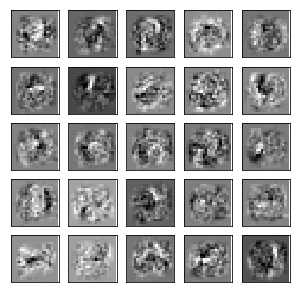

In [270]:
plot_hidden_layer(final_theta)
plt.show()